# US Car Accidents

## Import

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import swifter
import scipy, math
from tqdm import tqdm

from collections import Counter

In [2]:
US_ACCIDENTS_PATH = os.path.join("..", "data", "US_Accidents_Dec19.csv")

For the meaning of each column refer to https://www.kaggle.com/sobhanmoosavi/us-accidents

Papers using this dataset:

    arXiv:1906.05409
    arXiv:1909.09638


In [3]:
df = pd.read_csv(US_ACCIDENTS_PATH)

In [4]:
df.shape

(2974335, 49)

In [5]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


## Remove NaNs

In [6]:
for name in df.columns:
    print(name + ": " + str(df[name].isna().sum()))

ID: 0
Source: 0
TMC: 728071
Severity: 0
Start_Time: 0
End_Time: 0
Start_Lat: 0
Start_Lng: 0
End_Lat: 2246264
End_Lng: 2246264
Distance(mi): 0
Description: 1
Number: 1917605
Street: 0
Side: 0
City: 83
County: 0
State: 0
Zipcode: 880
Country: 0
Timezone: 3163
Airport_Code: 5691
Weather_Timestamp: 36705
Temperature(F): 56063
Wind_Chill(F): 1852623
Humidity(%): 59173
Pressure(in): 48142
Visibility(mi): 65691
Wind_Direction: 45101
Wind_Speed(mph): 440840
Precipitation(in): 1998358
Weather_Condition: 65932
Amenity: 0
Bump: 0
Crossing: 0
Give_Way: 0
Junction: 0
No_Exit: 0
Railway: 0
Roundabout: 0
Station: 0
Stop: 0
Traffic_Calming: 0
Traffic_Signal: 0
Turning_Loop: 0
Sunrise_Sunset: 93
Civil_Twilight: 93
Nautical_Twilight: 93
Astronomical_Twilight: 93


In [7]:
# removing End_Lat, End_Lng, Number, Wind Chill, Precipitation 
df = df.drop(["End_Lat", "End_Lng", "Number", "Wind_Chill(F)", "Precipitation(in)"], axis=1)

In [8]:
# check if ID is unique
df["ID"].nunique() == df.shape[0]

True

In [9]:
# convert object type into datetime64 type
df["Start_Time"] = pd.to_datetime(df["Start_Time"])
df["End_Time"] = pd.to_datetime(df["End_Time"])

In [10]:
# it is useless, data is only from US
df["Country"].nunique()

1

In [11]:
# it is useless, always False
df["Turning_Loop"].nunique()

1

In [12]:
df = df.drop(["Country", "Turning_Loop"], axis=1)

Keep only the 40 most common weather conditions and replace all the others with "Other"

In [13]:
replacement_list = df["Weather_Condition"].value_counts()[40:].index
replacement_dict = {i: "Other" for i in replacement_list}

In [14]:
df.replace({'Weather_Condition': replacement_dict}, inplace=True)

In [15]:
df.dtypes

ID                               object
Source                           object
TMC                             float64
Severity                          int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                       float64
Start_Lng                       float64
Distance(mi)                    float64
Description                      object
Street                           object
Side                             object
City                             object
County                           object
State                            object
Zipcode                          object
Timezone                         object
Airport_Code                     object
Weather_Timestamp                object
Temperature(F)                  float64
Humidity(%)                     float64
Pressure(in)                    float64
Visibility(mi)                  float64
Wind_Direction                   object
Wind_Speed(mph)                 float64


# Partial EDA

## Source

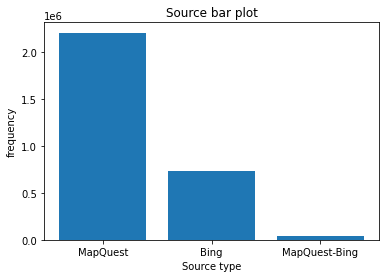

In [16]:
source_vc = df["Source"].value_counts()

plt.bar(source_vc.index, source_vc.values)
plt.title("Source bar plot")
plt.xlabel("Source type")
plt.ylabel("frequency")
plt.show()

## Time

### Generic

In [22]:
start_time = df["Start_Time"].swifter.apply(lambda x: x.time())
start_hour = start_time.swifter.apply(lambda x: x.hour)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2974335 [00:00<?, ?it/s]

In [23]:
end_time = df["End_Time"].swifter.apply(lambda x: x.time())
end_hour = end_time.swifter.apply(lambda x: x.hour)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2974335 [00:00<?, ?it/s]

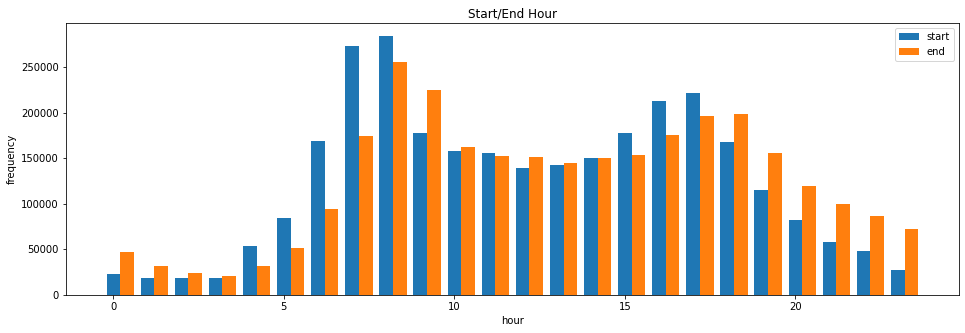

In [24]:
sh_vc = start_hour.value_counts().sort_index()
eh_vc = end_hour.value_counts().sort_index()

plt.figure(figsize=(16,5))
plt.bar(sh_vc.index, sh_vc.values, width=0.4, label="start")
plt.bar(eh_vc.index+0.4, eh_vc.values, width=0.4, label="end")
plt.title("Start/End Hour")
plt.xlabel("hour")
plt.ylabel("frequency")
plt.legend()
plt.show()

### Weekend

In [25]:
start_time_wd = df["Start_Time"].swifter.apply(lambda x: x.weekday())
start_time_weekend = start_time[(start_time_wd == 5) | (start_time_wd == 6)]
start_hour_weekend = start_time_weekend.apply(lambda x: x.hour)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [26]:
end_time_wd = df["End_Time"].swifter.apply(lambda x: x.weekday())
end_time_weekend = end_time[(end_time_wd == 5) | (end_time_wd == 6)]
end_hour_weekend = end_time_weekend.apply(lambda x: x.hour)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

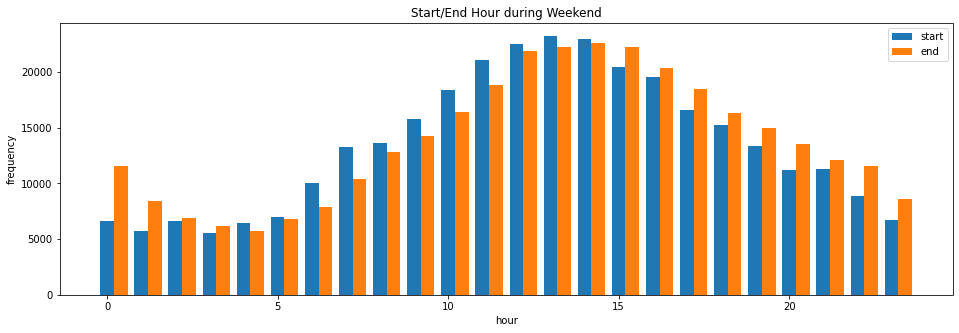

In [27]:
sh_wk = start_hour_weekend.value_counts().sort_index()
eh_wk = end_hour_weekend.value_counts().sort_index()


plt.figure(figsize=(16,5))
plt.bar(sh_wk.index, sh_wk.values, width=0.4, label="start")
plt.bar(eh_wk.index+0.4, eh_wk.values, width=0.4, label="end")
plt.title("Start/End Hour during Weekend")
plt.xlabel("hour")
plt.ylabel("frequency")
plt.legend()
plt.show()

### Working days

In [28]:
start_time_work = start_time[(start_time_wd != 5) & (start_time_wd != 6)]
start_hour_work = start_time_work.apply(lambda x:x.hour)

In [29]:
end_time_work = end_time[(end_time_wd != 5) & (end_time_wd != 6)]
end_hour_work = end_time_work.apply(lambda x:x.hour)

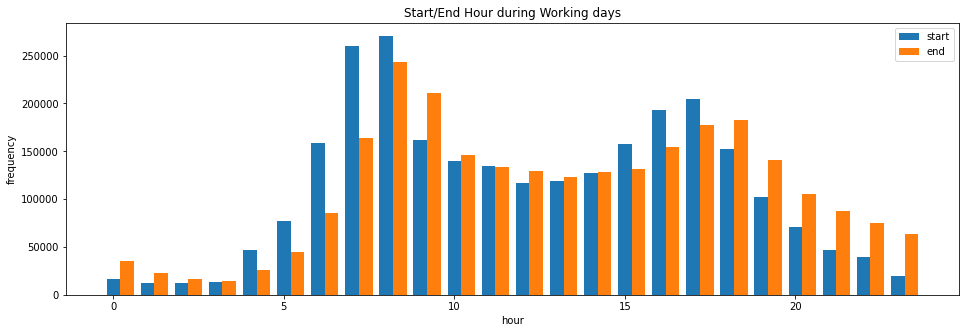

In [31]:
sh_wk = start_hour_work.value_counts().sort_index()
eh_wk = end_hour_work.value_counts().sort_index()


plt.figure(figsize=(16,5))
plt.bar(sh_wk.index, sh_wk.values, width=0.4, label="start")
plt.bar(eh_wk.index+0.4, eh_wk.values, width=0.4, label="end")
plt.title("Start/End Hour during Working days")
plt.xlabel("hour")
plt.ylabel("frequency")
plt.legend()
plt.show()

## TMC

There are 728071 NaN in the TMC column.


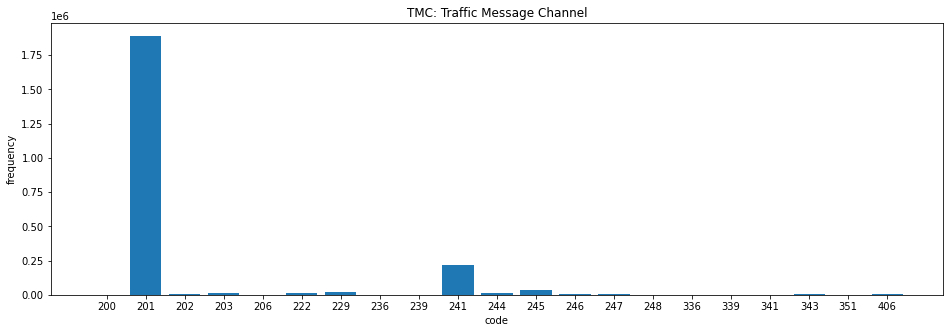

In [33]:
print("There are {} NaN in the TMC column.".format(df["TMC"].isna().sum()))

TMC_vc = df["TMC"].value_counts().sort_index()
plt.figure(figsize=(16,5))
plt.bar(TMC_vc.index.map(lambda x: str(int(x))), TMC_vc.values)
plt.title("TMC: Traffic Message Channel")
plt.xlabel("code")
plt.ylabel("frequency")
plt.show()

## Severity

/Users/guglielmosanchini/PycharmProjects/Personal/StatisticsPy/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


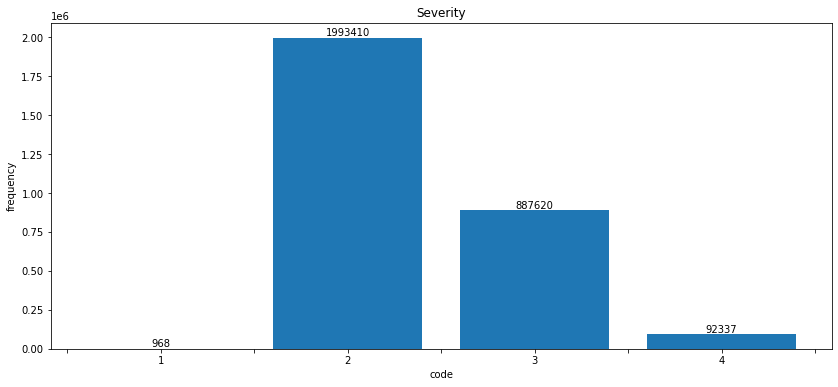

In [34]:
sev_vc = df["Severity"].value_counts(dropna=False).sort_index()

plt.figure(figsize=(14,6))
plt.bar(sev_vc.index, sev_vc.values)
plt.title("Severity")
plt.xlabel("code")
plt.ylabel("frequency")
plt.gca().set_xticklabels([None,None,1,None, 2, None, 3, None, 4])


for i, v in enumerate(sev_vc.values):
    plt.text(i+1, v+15000, str(v), color='black', fontweight=None, ha="center")

plt.show()

## Distance

In [35]:
# too many distances are equal to zero
print("null distances : ",(df["Distance(mi)"]==0).sum())
print("distances <=0.1: ", (df["Distance(mi)"]<=0.1).sum())

null distances :  1996120
distances <=0.1:  2357571


In [36]:
dist_nonnull = df["Distance(mi)"][df["Distance(mi)"] != 0]

In [37]:
p_95 = np.percentile(dist_nonnull,95)
print("95th percentile: ", p_95)

95th percentile:  3.41000008583


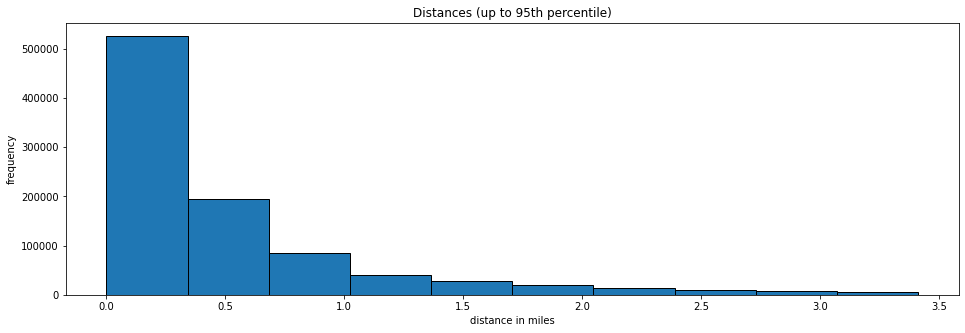

In [38]:
plt.figure(figsize=(16,5))
plt.hist(dist_nonnull[dist_nonnull <= p_95], edgecolor="k")
plt.title("Distances (up to 95th percentile)")
plt.xlabel("distance in miles")
plt.ylabel("frequency")
plt.show()

## Categorical Variables

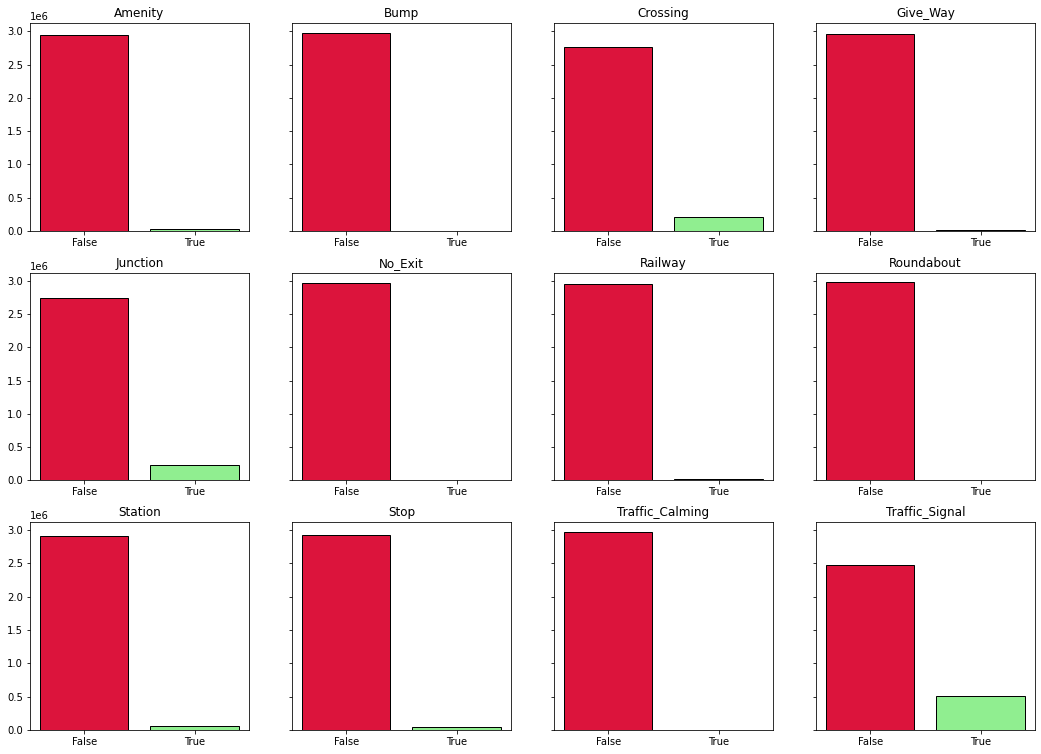

In [39]:
fig, ax = plt.subplots(3,4, figsize=(18,13), sharey=True)

ind1 = 0
ind2 = 0
for name in df.columns:
    if df[name].dtype == "bool":
        vc = df[name].value_counts()
        ax[ind2, ind1].set_title(name)
        ax[ind2, ind1].bar(vc.index.map(lambda x: str(x)), vc.values, 
                           color=["crimson", "lightgreen"], edgecolor="k")
        ind1 += 1
        if ind1 == 4:
            ind1 = 0
            ind2 += 1
plt.show()

# Description

In [40]:
len_descr = df["Description"].apply(lambda x: len(str(x).split(" ")))

In [41]:
print("Normalized contingency table of Severity and Description Length")

sev_len_df = pd.crosstab(df["Severity"], pd.qcut(len_descr, 10, duplicates="drop"), 
            margins=True, normalize="columns")

sev_len_df.style.background_gradient(cmap='coolwarm').set_precision(3)

Normalized contingency table of Severity and Description Length


Description,"(0.999, 6.0]","(6.0, 7.0]","(7.0, 8.0]","(8.0, 9.0]","(9.0, 10.0]","(10.0, 12.0]","(12.0, 14.0]","(14.0, 16.0]","(16.0, 75.0]",All
Severity,,,,,,,,,,
1,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000
2,0.846,0.925,0.883,0.730,0.587,0.548,0.422,0.369,0.302,0.670
3,0.152,0.073,0.116,0.246,0.314,0.363,0.522,0.594,0.670,0.298
4,0.003,0.001,0.001,0.023,0.098,0.089,0.056,0.037,0.028,0.031


In [42]:
print("Normalized contingency table of Distance (in miles) and Description Length")

dist_len_df = pd.crosstab(pd.qcut(df["Distance(mi)"], 50, duplicates="drop"), 
                         pd.qcut(len_descr, 10, duplicates="drop"), 
                         margins=True, normalize="columns")

dist_len_df.style.background_gradient(cmap='viridis').set_precision(3)

Normalized contingency table of Distance (in miles) and Description Length


Description,"(0.999, 6.0]","(6.0, 7.0]","(7.0, 8.0]","(8.0, 9.0]","(9.0, 10.0]","(10.0, 12.0]","(12.0, 14.0]","(14.0, 16.0]","(16.0, 75.0]",All
Distance(mi),,,,,,,,,,
"(-1e-08, 0.0099999998]",0.418,0.807,0.787,0.727,0.649,0.671,0.723,0.732,0.617,0.682
"(0.0099999998, 0.01]",0.017,0.068,0.076,0.096,0.090,0.096,0.110,0.137,0.127,0.084
"(0.01, 0.05]",0.054,0.012,0.011,0.009,0.010,0.007,0.002,0.001,0.001,0.014
"(0.05, 0.132]",0.071,0.013,0.012,0.014,0.019,0.015,0.006,0.003,0.003,0.020
"(0.132, 0.217]",0.064,0.014,0.013,0.016,0.021,0.019,0.008,0.004,0.003,0.020
"(0.217, 0.305]",0.060,0.013,0.013,0.017,0.022,0.019,0.009,0.005,0.005,0.020
"(0.305, 0.398]",0.060,0.013,0.012,0.019,0.022,0.018,0.009,0.005,0.006,0.020
"(0.398, 0.489]",0.061,0.013,0.014,0.018,0.021,0.016,0.009,0.005,0.006,0.020
"(0.489, 0.592]",0.060,0.013,0.013,0.017,0.021,0.017,0.010,0.007,0.008,0.020


# Correlations

Article on TowardsDataScience about categorical correlation:
    https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

Article on medium on the same topic:
    https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

## Continuos variables

In [43]:
numeric_columns = []
for name in df.columns:
    if (df[name].dtype == "float64"):
        numeric_columns.append(name)

In [44]:
corr = df[numeric_columns].corr()

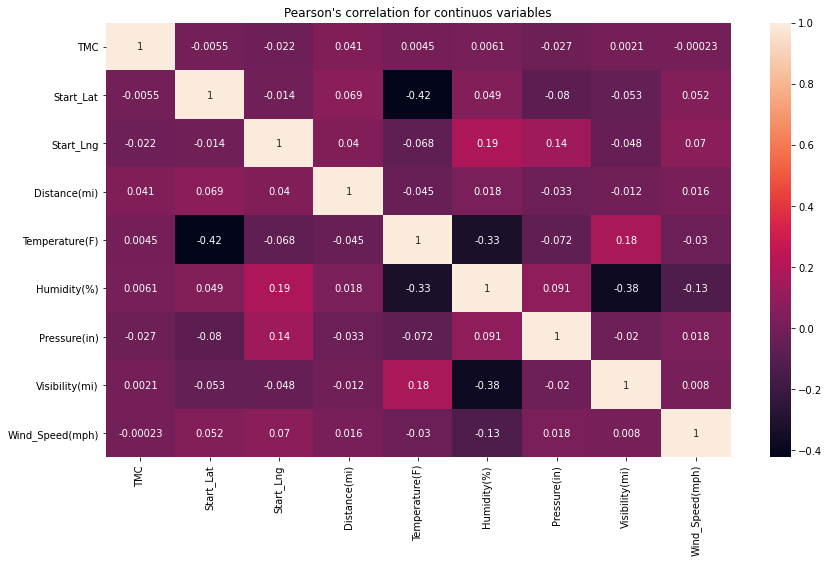

In [45]:
plt.figure(figsize=(14,8))
plt.title("Pearson's correlation for continuos variables")
sns.heatmap(corr, annot=True)
plt.show()

In [46]:
corr.style.background_gradient(cmap='coolwarm')\
    .set_properties(**{'max-width': '70px', 'font-size': '12pt'})\
    .set_precision(2)

,TMC,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph)
TMC,1.00,-0.01,-0.02,0.04,0.00,0.01,-0.03,0.00,-0.00
Start_Lat,-0.01,1.00,-0.01,0.07,-0.42,0.05,-0.08,-0.05,0.05
Start_Lng,-0.02,-0.01,1.00,0.04,-0.07,0.19,0.14,-0.05,0.07
Distance(mi),0.04,0.07,0.04,1.00,-0.04,0.02,-0.03,-0.01,0.02
Temperature(F),0.00,-0.42,-0.07,-0.04,1.00,-0.33,-0.07,0.18,-0.03
Humidity(%),0.01,0.05,0.19,0.02,-0.33,1.00,0.09,-0.38,-0.13
Pressure(in),-0.03,-0.08,0.14,-0.03,-0.07,0.09,1.00,-0.02,0.02
Visibility(mi),0.00,-0.05,-0.05,-0.01,0.18,-0.38,-0.02,1.00,0.01
Wind_Speed(mph),-0.00,0.05,0.07,0.02,-0.03,-0.13,0.02,0.01,1.00


## Categorical Variables

In [47]:
# https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

def chi2_test(crosstab, prob=0.95, details=True):

    # chi-squared test with similar proportions
    from scipy.stats import chi2_contingency
    from scipy.stats import chi2

    # contingency table
    table = crosstab
    stat, p, dof, expected = chi2_contingency(table)
    critical = chi2.ppf(prob, dof)
    
    if details == True:
        print('degrees of freedom = {}'.format(dof))
        print('stat = {}'.format(stat))
        print('p-value = {}'.format(p))

        print('prob = {}'.format(prob))
        print('critical value = {}'.format(critical))

    if abs(stat) >= critical:
        print('Dependent')
        
        res = 1
        
        return res
    
    else:
        print('Independent') 
        
        res = 0
      
        return res

In [48]:
cat = []
for col in df.columns:
    if df[col].dtype == "bool":
        cat.append(col)

In [49]:
matrix = []
for col_1 in cat:
    for col_2 in cat:
        print(col_1,"---", col_2)
        matrix.append(chi2_test(pd.crosstab(df[col_1], df[col_2]), details=False))
        print("\n")

Amenity --- Amenity
Dependent


Amenity --- Bump
Dependent


Amenity --- Crossing
Dependent


Amenity --- Give_Way
Dependent


Amenity --- Junction
Dependent


Amenity --- No_Exit
Dependent


Amenity --- Railway
Dependent


Amenity --- Roundabout
Independent


Amenity --- Station
Dependent


Amenity --- Stop
Dependent


Amenity --- Traffic_Calming
Dependent


Amenity --- Traffic_Signal
Dependent


Bump --- Amenity
Dependent


Bump --- Bump
Dependent


Bump --- Crossing
Dependent


Bump --- Give_Way
Independent


Bump --- Junction
Dependent


Bump --- No_Exit
Dependent


Bump --- Railway
Independent


Bump --- Roundabout
Dependent


Bump --- Station
Dependent


Bump --- Stop
Dependent


Bump --- Traffic_Calming
Dependent


Bump --- Traffic_Signal
Dependent


Crossing --- Amenity
Dependent


Crossing --- Bump
Dependent


Crossing --- Crossing
Dependent


Crossing --- Give_Way
Dependent


Crossing --- Junction
Dependent


Crossing --- No_Exit
Dependent


Crossing --- Railway
Dependent


C

1 means DEPENDENT, 0 means INDEPENDENT


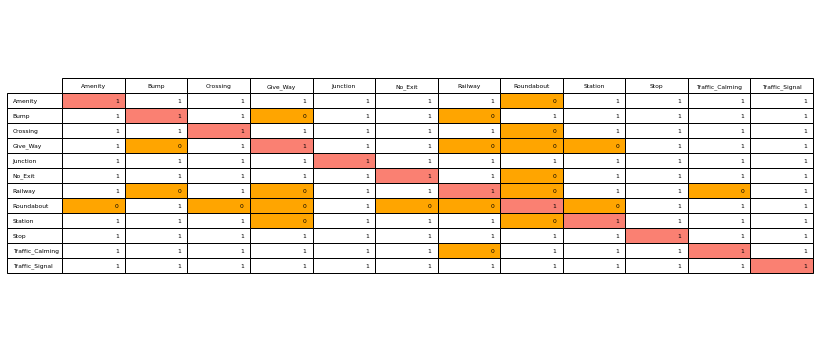

In [50]:
data = np.array(matrix).reshape(12,12)
fig, ax = plt.subplots(figsize=(12,5))

# create color matrix to highlight table entries
D = np.empty((12,12), dtype=object)
for i in range(12):
    for j in range(12):
        if data[i,j] == 1:
            if i == j:
                D[i,j] = "salmon"
            else:
                D[i,j] = "white"
        else:
            D[i,j] = "orange"

print("1 means DEPENDENT, 0 means INDEPENDENT")
            
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=data, colLabels=cat, rowLabels=cat, loc='center', cellColours=D)

fig.tight_layout()

plt.show()

In [51]:
cat_mod = []
for col in df.columns:
    if col != "ID" and col != "Description":
        if (df[col].dtype == "bool") or (df[col].dtype == "int64"):
            cat_mod.append(col)

cat_mod.append("Wind_Direction")
cat_mod.append("Weather_Condition")
cat_mod.append("Sunrise_Sunset")

In [53]:
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
# https://en.wikipedia.org/wiki/Correlation_ratio

#all taken from dython library, with slight modifications

def cramers_v_MOD(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u_MOD(x,y):
    s_xy = conditional_entropy_MOD(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = scipy.stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def conditional_entropy_MOD(x,y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy)
    return entropy

def correlation_ratio_MOD(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [56]:
matrix2 = []
for col_1 in tqdm(cat_mod):
    for col_2 in cat_mod:
        matrix2.append(cramers_v_MOD(df[col_1], df[col_2]))

100%|██████████| 16/16 [01:01<00:00,  3.83s/it]


In [57]:
matrix3 = []
for col_1 in tqdm(cat_mod):
    for col_2 in cat_mod:
        matrix3.append(theils_u_MOD(df[col_1], df[col_2]))

100%|██████████| 16/16 [06:58<00:00, 26.14s/it]


In [61]:
CramV_df = pd.DataFrame(np.array(matrix2).reshape(len(cat_mod), 
                                                  len(cat_mod)), 
                        columns=cat_mod, index=cat_mod).apply(lambda x: round(x, 3))

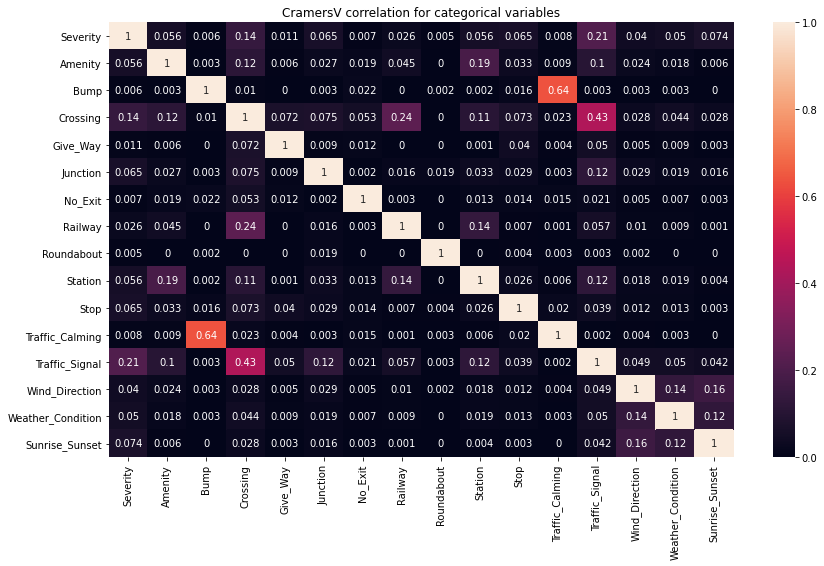

In [62]:
plt.figure(figsize=(14, 8))
plt.title("CramersV correlation for categorical variables")
sns.heatmap(CramV_df, annot=True)
plt.show()

In [63]:
TheilsU_df = pd.DataFrame(np.array(matrix3).reshape(len(cat_mod), len(cat_mod)), 
             columns=cat_mod, index=cat_mod).apply(lambda x: round(x, 3))

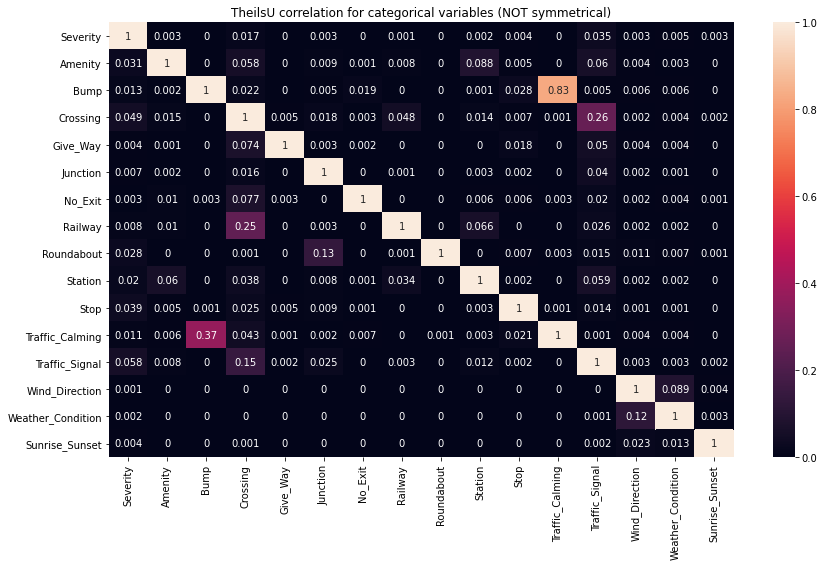

In [64]:
plt.figure(figsize=(14, 8))
plt.title("TheilsU correlation for categorical variables (NOT symmetrical)")
sns.heatmap(TheilsU_df, annot=True)
plt.show()

## Categorical against Continuos

In [68]:
continuos_features = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)',
                      'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

In [69]:
from dython.nominal import correlation_ratio

In [71]:
matrix4 = []
for col_1 in tqdm(cat_mod):
    for col_2 in continuos_features:
        matrix4.append(correlation_ratio(df[col_1], df[col_2]))     

100%|██████████| 16/16 [02:14<00:00,  8.42s/it]


In [72]:
Corr_Ratio_df = pd.DataFrame(np.array(matrix4).reshape(len(cat_mod), 
                                                       len(continuos_features)), 
                 columns=continuos_features, index=cat_mod).apply(lambda x: round(x, 3))

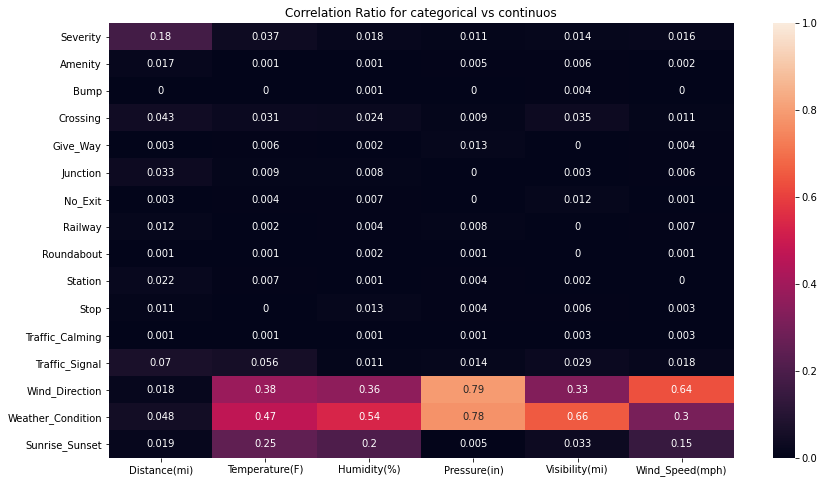

In [73]:
plt.figure(figsize=(14, 8))
plt.title("Correlation Ratio for categorical vs continuos")
sns.heatmap(Corr_Ratio_df, annot=True, vmax=1)
plt.show()